# Homework 2 (Linear models, Optimization)

In this homework you will implement a simple linear classifier using numpy and your brain.

In [1]:
%matplotlib inline

## Two-dimensional classification

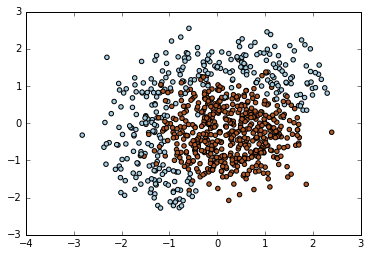

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from sklearn import datasets, preprocessing

# prepare dataset with two circles
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:, 1] > X[:, 0] - 0.5)
X = X[ind, :]
X = preprocessing.scale(X)
y = y[ind]
y = 2 * y - 1

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.show()

In [3]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h1 = (x_max - x_min) / 300
h2 = (y_max - y_min) / 300
xx, yy = np.meshgrid(np.arange(x_min, x_max, h1), np.arange(y_min, y_max, h2))


def visualize(X, y, w, loss, n_iter):
    plt.clf()
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.grid(True)
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())

**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [4]:
def expand(X):
    # add quadratic features
    X_ = np.zeros((X.shape[0], 6))
    X_[:, 0:2] = X
    X_[:, 2:4] = X**2
    X_[:, 4] = X[:,0] * X[:,1]
    X_[:, 5] = 1
    return X_

def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    X_expanded = expand(X)
    return np.where(np.dot(X_expanded, w) > 0, 1, -1)

The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [5]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    X_expanded = expand(X)
    loss = 1 - y * np.dot(X_expanded, w).T
    loss[loss < 0] = 0
    loss = np.average(loss)
    return loss

    
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    X_expanded = expand(X)
    indicator = np.where(1 - y * np.dot(X_expanded, w).T > 0, 1, 0)
    loss_derivative =  np.dot(X_expanded.T, - indicator * y) / len(y)
    return loss_derivative

### supplementary optimization code

In [6]:
def test_optimization(method, random_state=42, n_iter=750, batch_size=4, **params):
    w = np.array([1, 0, 0, 0, 0, 0])
    loss = np.zeros(n_iter)
    plt.figure(figsize=(12, 5))
    v = 0
    g = 0
    if random_state is not None:
        # fix random state to compare similar optimizations in the same environment
        random.seed(random_state)
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = compute_loss(X, y, w)
        if i % 100 == 0:
            visualize(X[ind, :], y[ind], w, loss, n_iter)

        if method == 'sgd':
            w = w - params['alpha'] * compute_grad(X[ind, :], y[ind], w)
        elif method == 'sgd+momentum':
            v = params['mu'] * v - params['alpha'] * compute_grad(X[ind, :], y[ind], w)
            w = w + v
        elif method == 'nesterov':
            v = params['mu'] * v - params['alpha'] * compute_grad(X[ind, :], y[ind], w + 10 * params['mu'] * v)
            w = w + v
        elif method == 'nesterov+':
            v = params['mu'] * v - compute_grad(X[ind, :], y[ind], w + params['mu'] * v)
            w = w + params['alpha'] * v
        elif method == 'adam':
            gradient = compute_grad(X[ind, :], y[ind], w)
            v = params['beta'] * v + (1 - params['beta']) * gradient
            g = params['mu'] * g + (1 - params['mu']) * gradient * gradient
            w = w - params['alpha'] * v / (np.sqrt(g / (1 - params['mu']** (i + 1))) + params['eps']) / (1 - params['beta'] ** (i + 1))
                    
    visualize(X, y, w, loss, n_iter)
    plt.clf()

## Training

Compare different optimizations
**Don't change the batch size!**

### Gradient descent with different learning rates

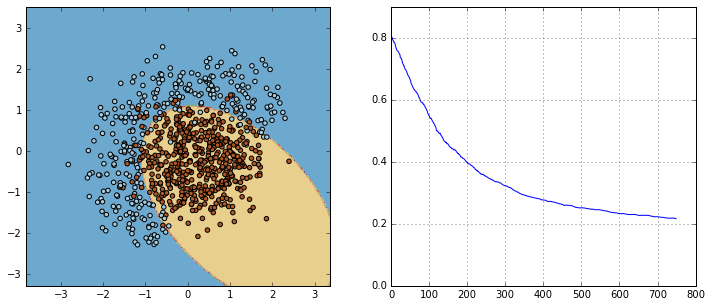

In [7]:
test_optimization(method='sgd', **dict(alpha=0.01))

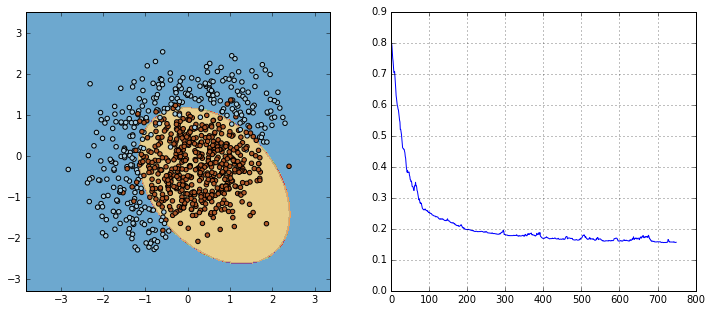

In [8]:
test_optimization(method='sgd', **dict(alpha=0.05))

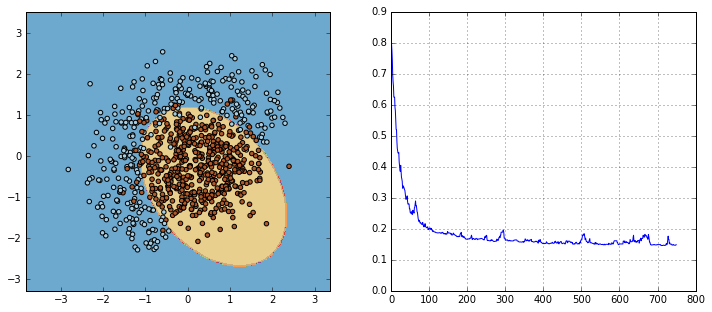

In [9]:
test_optimization(method='sgd', **dict(alpha=0.1))

### Gradient descent with momentum (test it's performance for different learning rate and momentum values)

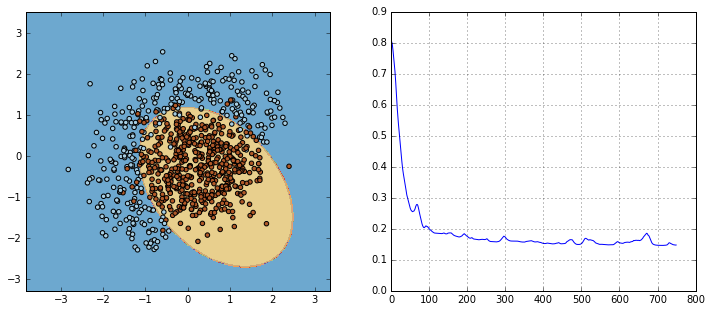

In [10]:
test_optimization(method='sgd+momentum', **dict(alpha=0.01, mu=0.9))

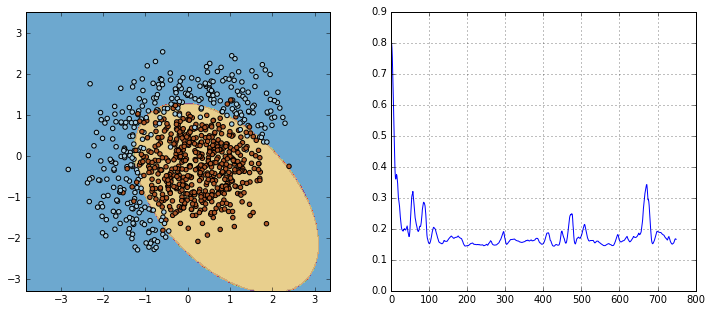

In [11]:
test_optimization(method='sgd+momentum', **dict(alpha=0.05, mu=0.9))

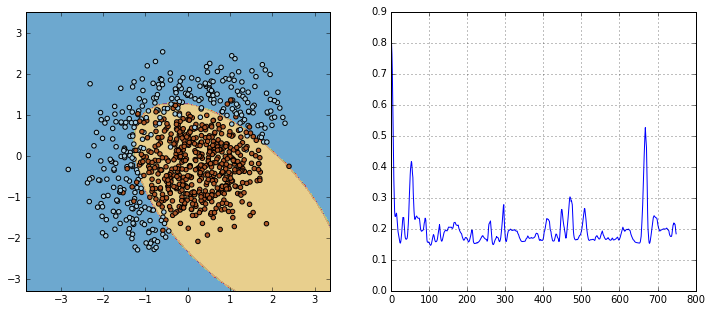

In [12]:
test_optimization(method='sgd+momentum', **dict(alpha=0.1, mu=0.9))

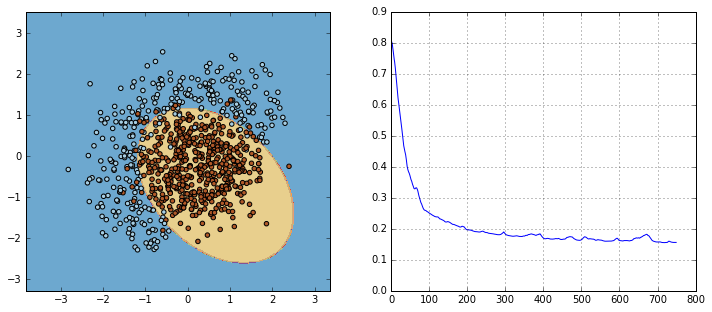

In [13]:
test_optimization(method='sgd+momentum', **dict(alpha=0.01, mu=0.8))

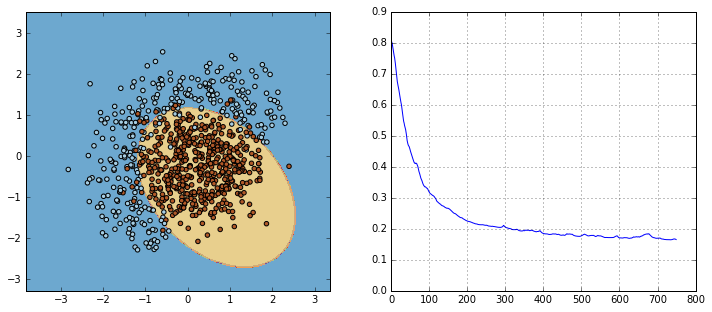

In [14]:
test_optimization(method='sgd+momentum', **dict(alpha=0.01, mu=0.7))

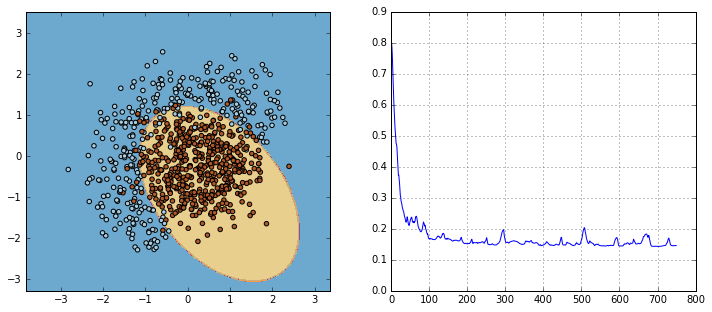

In [15]:
test_optimization(method='sgd+momentum', **dict(alpha=0.05, mu=0.7))

SGD with momentum haы smoother picture for loss dependence than SGD due to accumulating momentum

### Nesterov's accelerated gradient:

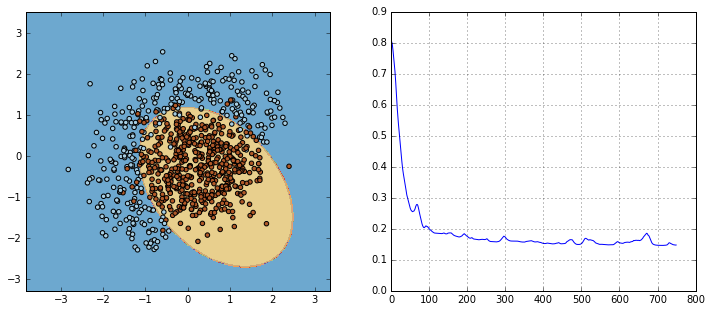

In [16]:
test_optimization(method='sgd+momentum', **dict(alpha=0.01, mu=0.9))

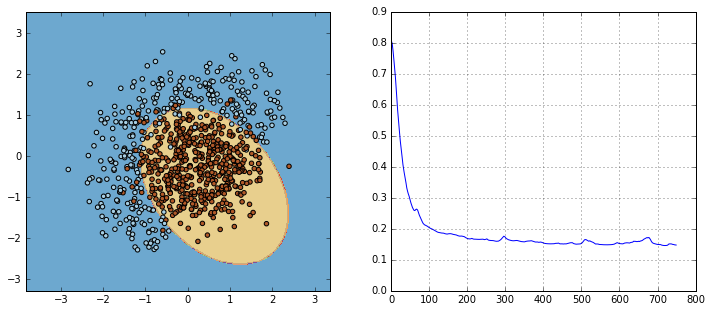

In [17]:
test_optimization(method='nesterov', **dict(alpha=0.01, mu=0.9))

Nesterov is similar to the simple momentum for the near-optimal parameters, however it is better.

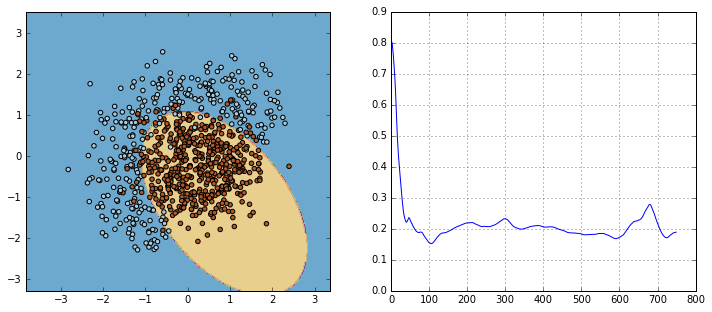

In [18]:
test_optimization(method='sgd+momentum', **dict(alpha=0.01, mu=0.99))

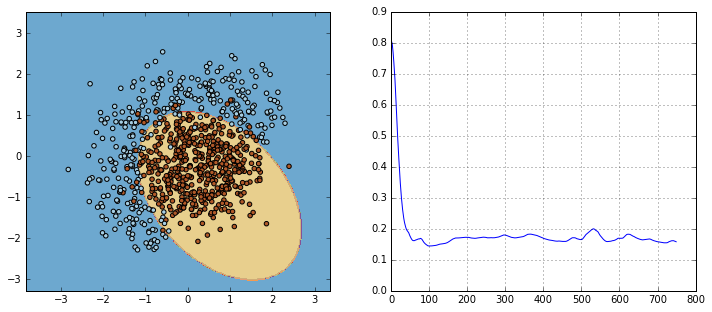

In [19]:
test_optimization(method='nesterov', **dict(alpha=0.01, mu=0.99))

Nesterov momentum provides less variation during convergence.

### ADAM optimization algorithm. 

You can start with beta = 0.9 and mu = 0.999

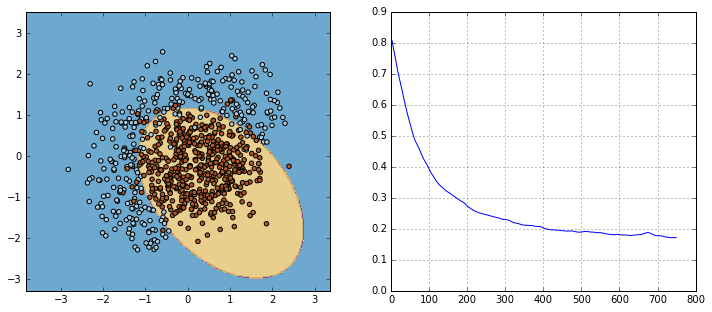

In [20]:
test_optimization(method='adam', **dict(alpha=0.01, mu=0.999, beta=0.9, eps=1e-8))

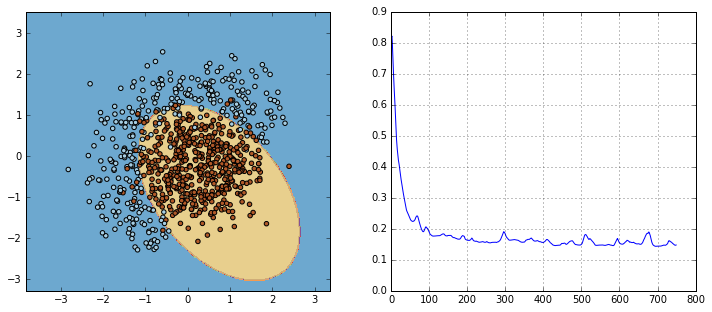

In [21]:
test_optimization(method='adam', **dict(alpha=0.05, mu=0.999, beta=0.9, eps=1e-8))

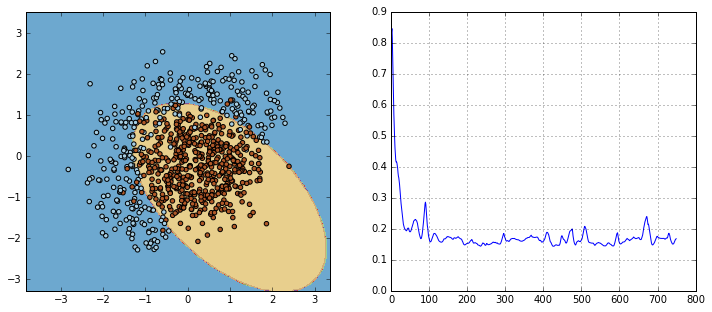

In [22]:
test_optimization(method='adam', **dict(alpha=0.1, mu=0.999, beta=0.9, eps=1e-8))

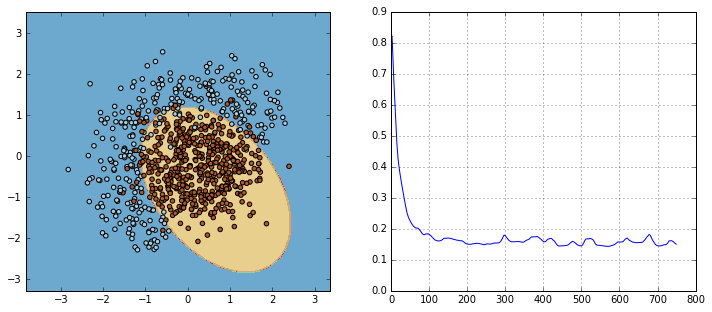

In [23]:
test_optimization(method='adam', **dict(alpha=0.05, mu=0.95, beta=0.95, eps=1e-8))

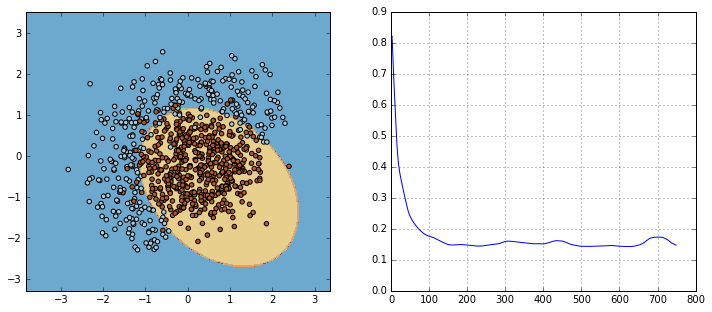

In [24]:
test_optimization(method='adam', **dict(alpha=0.05, mu=0.999, beta=0.99, eps=1e-8))

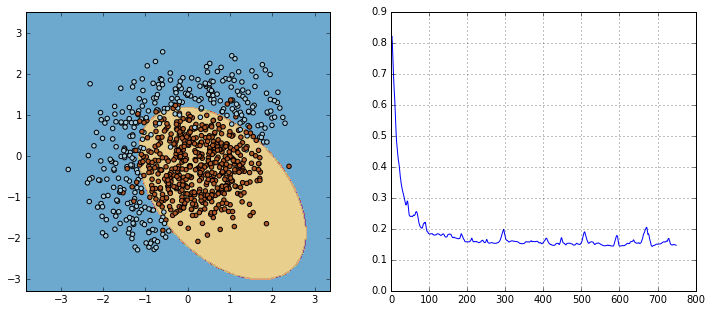

In [25]:
test_optimization(method='adam', **dict(alpha=0.05, mu=0.999, beta=0.8, eps=1e-8))

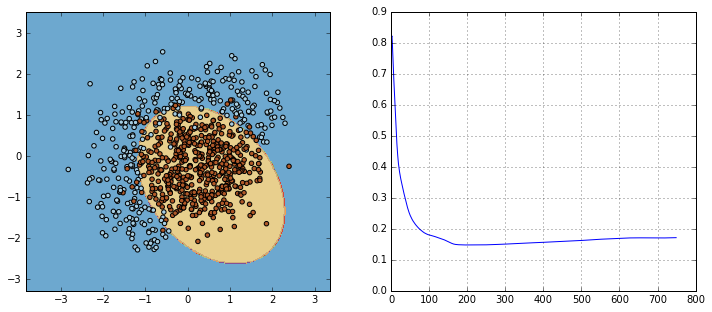

In [26]:
test_optimization(method='adam', **dict(alpha=0.05, mu=0.999, beta=0.999, eps=1e-8))

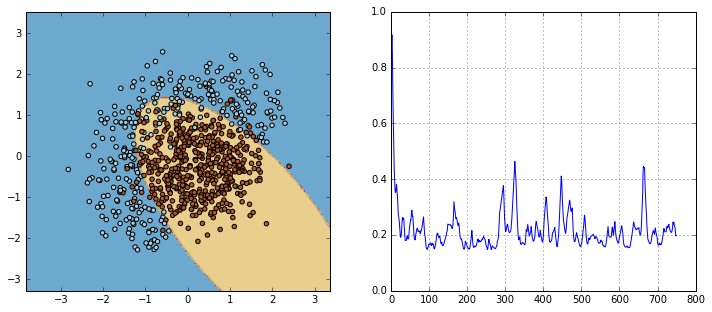

In [27]:
test_optimization(method='adam', **dict(alpha=0.2, mu=0.8, beta=0.8, eps=1e-8))

## Do rescaling and compare algorithms

In [28]:
X[:, 1] = X[:, 1] * 10

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h1 = (x_max - x_min) / 300
h2 = (y_max - y_min) / 300
xx, yy = np.meshgrid(np.arange(x_min, x_max, h1), np.arange(y_min, y_max, h2))

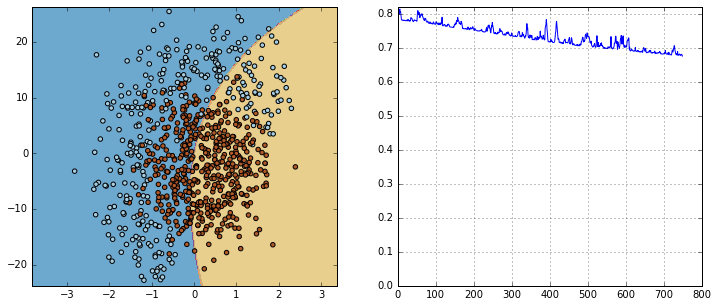

In [29]:
test_optimization(method='sgd', **dict(alpha=0.00001))

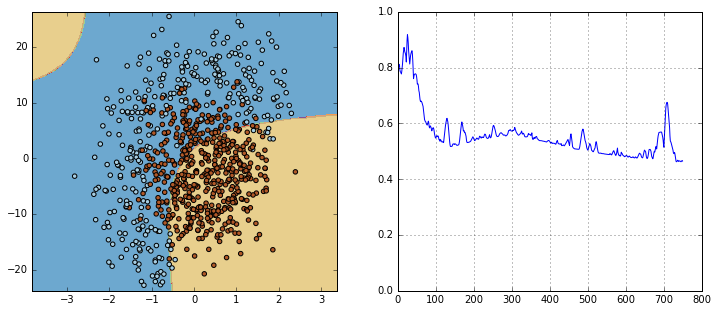

In [30]:
test_optimization(method='nesterov', **dict(alpha=0.00001, mu=0.99))

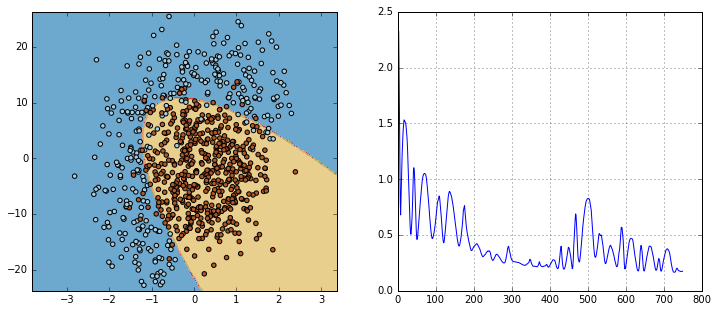

In [31]:
test_optimization(method='adam', **dict(alpha=0.01, mu=0.999, beta=0.97, eps=1e-8))

#### Which optimization method do you consider the best? Type your answer in the cell below

- All methods are very unstable to the repeated runs with the same settings. 
- On this toy dataset the best optimization method is ADAM, however SGD with momentum (and Nesterov momentum) provides similar results
- On unscaled data ADAM provides the best convergence